In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def generate_color_list(n):
    # Use a colormap to generate n distinct colors
    cmap = plt.get_cmap('hsv')
    colors = [cmap(i / n) for i in range(n)]
    return colors

n = 10
colors = generate_color_list(n)

In [37]:
inner1 = Polygon([(0.5, 0.8), (0.7, 0.8), (0.8, 0.6), (0.6, 0.4), (0.8, 0.2), (0.4, 0.1), (0.2, 0.4)])

triangle = Polygon([(0.2, 0.2), (0.4, 0.8), (0.6, 0.2)])
square = Polygon([(0.7, 0.7), (0.9, 0.7), (0.9, 0.9), (0.7, 0.9)])
inner2 = MultiPolygon([triangle, square])

points = [(0.1, 0.2), (0.4, 0.7), (0.8, 0.8), (0.3, 0.9), (0.6, 0.3)]
inner3 = MultiPoint(points)

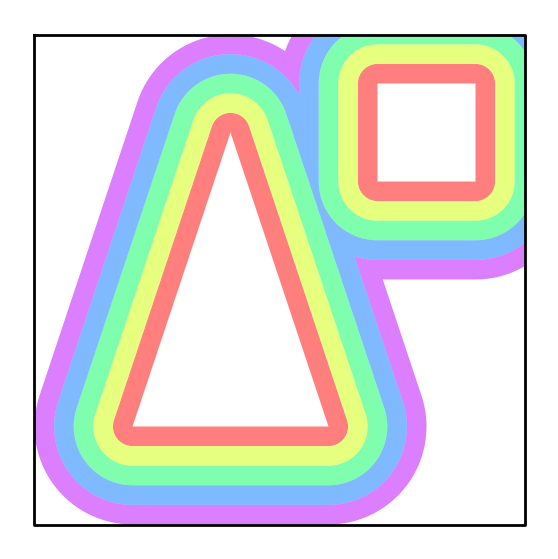

In [84]:
def get_circles(outer, inner, n_steps, max_distance=0.2, do_plot=False):

    target_outers = np.linspace(0, max_distance, n_steps+1)[1:]

    shapes = [inner]

    # for distance in target_outers:
    distance = target_outers[0]

    for _ in range(n_steps):
        shapes.append(shapes[-1].buffer(distance))

    rings = {}

    # for outer_ring, to_exclude in zip(shapes[::-1], shapes[1::-1]):
    for outer_ring, to_exclude, distance in zip(shapes[1:], shapes, target_outers):

        new_ring = outer_ring.difference(to_exclude).intersection(outer)
        rings[distance] = new_ring
        
    
    if do_plot:
        _, ax = plt.subplots(figsize=(7, 7))

        ax.plot(*outer.exterior.xy, linewidth=2, color='black')

        for ring, c in zip(rings.values(), generate_color_list(n_steps)):
            gpd.GeoSeries([ring]).plot(ax=ax, alpha=0.5, color=c)

        for border in ['top', 'bottom', 'left', 'right']:
            ax.spines[border].set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()

    return rings


outer = Polygon([(0, 1), (1, 1), (1, 0), (0, 0)])

n = 5
# rings = get_circles(outer, inner1, n, do_plot=True)
rings = get_circles(outer, inner2, n, do_plot=True)
# rings = get_circles(outer, inner3, n, do_plot=True)

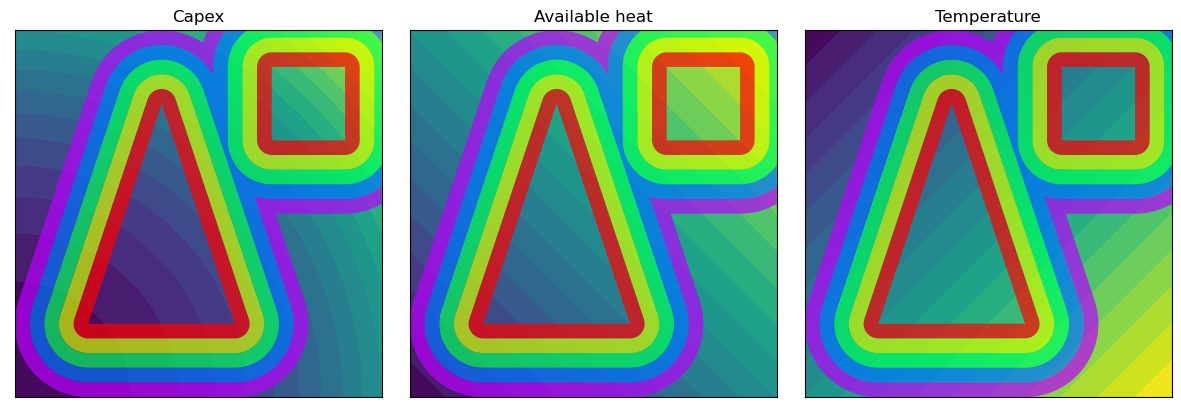

In [85]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

x, y = np.meshgrid(x, y)

capex = x**2 + y**2
available_heat = x + y
temperature = x - y

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, data, title in zip(axs, [capex, available_heat, temperature], ['Capex', 'Available heat', 'Temperature']):

    # ax.imshow(data, cmap='viridis')
    ax.contourf(x, y, data, levels=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    for ring, c in zip(rings.values(), generate_color_list(n)):
        gpd.GeoSeries([ring]).plot(ax=ax, alpha=0.7, color=c)

plt.tight_layout()
plt.show()

In [86]:
def get_region_value(x, y, shape, zeroth, first):

    geometries = gpd.points_from_xy(x.flatten(), y.flatten())
    mask = geometries.within(shape)

    if isinstance(zeroth, list):
        zeroth = pd.DataFrame({i: d.flatten() for i, d in enumerate(zeroth)})

    if isinstance(first, list):
        first = pd.DataFrame({i: d.flatten() for i, d in enumerate(first)})

    zeroth = zeroth.loc[mask].mean()
    first = first.loc[mask].sum()

    return zeroth, first


mean_data = pd.DataFrame({'capex': capex.flatten(), 'temp': temperature.flatten()})
cumulative_data = pd.DataFrame({'heat': available_heat.flatten()})

totals = []

for distance, ring in rings.items():
    zeroth, first = get_region_value(x, y, ring, mean_data, cumulative_data)

    totals.append(pd.concat([zeroth, first], axis=0).rename(distance))

pd.concat(totals, axis=1)

,0.04,0.08,0.12,0.16,0.20
capex,0.714650,0.749674,0.687370,0.587964,0.542551
temp,-0.015587,-0.018681,-0.018532,-0.015202,-0.006144
heat,1168.686869,1419.848485,1335.939394,1109.707071,873.858586
